# USDA Python Training

## A Brief Primer on Land/Water Masks

There are several ways to attempt to produce a land/water mask, but one way that is used 
(as defined by McFeeters 1996) is calculating NDWI, or Normalized Difference Water Index.

As originally defined, NDWI used the NIR and SWIR bands. This is sensitive to moisture content in leaves.
If we want to look at simple land/water body delineation, then using the McFeeters method, which uses the
Green band in place of SWIR.

There is also the Modified NDWI (or MNDWI), which purports to improve the McFeeters version by replacing NIR with
SWIR. The dataset we're using today does not have SWIR, but does have Green and NIR.

As defined by the index, we are looking at the following ranges for various land/water entities.

| Value | Class |
|-----|-----|
| 0.0 to 0.2 | Humidity/flooding |
| 0.2 to 1.0 | Water surface |
|-0.3 to 0.0 | Moderate drought, non-aqueous surface |
|-1.0 to -0.3 | Drought, non-aqueous surface |

In [90]:
# Bring in our libraries - GDAL and OSR for reading GeoTIFFs, NumPy for array
# manipulation, matplotlib for displaying imagery

import os, sys

from osgeo import gdal
from osgeo import osr
from osgeo import ogr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cv2


## Opening Files With GDAL

We use the "Open" command of GDAL to get a pointer to a file object. Put the file name in quotes
if you're already in the correct directory (i.e. in the same folder as the notebook), but if in
a different directory, then you need to give a full file path to the data.

We also want to grab our projection and spatial reference. We can easily get this from a GeoTIFF
using the "GetProjection" function, and then parse the Well-Known Text (WKT) we retrieved using
the "SpatialReference" function to create a projection object that we can use later on.

In [94]:
# Open the image file
img = gdal.Open("2021-11-04_Turnage_Florida_Flight2_Clip_BGREN.tif")

# Get our image's geographic information
geotransform = img.GetGeoTransform()
wkt = img.GetProjection()
proj = osr.SpatialReference(wkt)

print (geotransform, "\n")
print (wkt, "\n")
print (proj, "\n")

(742953.08968, 0.033410000000007, 0.0, 3371817.1062400006, 0.0, -0.03340999999996251) 

PROJCS["WGS 84 / UTM zone 16N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32616"]] 

PROJCS["WGS 84 / UTM zone 16N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174

## Reading Raster Bands and Putting Into NumPy Arrays

To retrieve a raster band, we use the "GetRasterBand" function. Note that these are indexed starting from one, not zero, so be careful
that you choose the correct band. This selects the band, but we also need to get it into an array to work with, so we use the
"ReadAsArray" function to read that raster band into an array.

In [95]:
# Read in our five bands. Note that you may not need all bands, but for
# availability we're going to bring in all of them.

# This will put the raster values for each band into a NumPy array.

blue = img.GetRasterBand(1).ReadAsArray()
green = img.GetRasterBand(2).ReadAsArray()
red = img.GetRasterBand(3).ReadAsArray()
rededge = img.GetRasterBand(4).ReadAsArray()
nir = img.GetRasterBand(5).ReadAsArray()

## Handling NoData Values

In most GeoTIFFs, a value has been defined as a "NoData" value. This is a value that various software will
treat as non-existent and not operate on those values. When we get these values, we want to go ahead and
tell NumPy that this particular value shouldn't be used, so we will turn all of those values to NaN using
the "where" function.

In [4]:
# Get our nodata value

# This may actually change based on each band - probably not common, but
# still possible.

nodata = img.GetRasterBand(1).GetNoDataValue()
blue = np.where(blue == nodata, np.nan, blue)
nodata = img.GetRasterBand(2).GetNoDataValue()
green = np.where(green == nodata, np.nan, green)
nodata = img.GetRasterBand(3).GetNoDataValue()
red = np.where(red == nodata, np.nan, red)
nodata = img.GetRasterBand(4).GetNoDataValue()
rededge = np.where(rededge == nodata, np.nan, rededge)
nodata = img.GetRasterBand(5).GetNoDataValue()
nir = np.where(nir == nodata, np.nan, nir)

## Changing the Size of Displayed Imagery

Some imagery might display rather small (or large), depending on what you're working with. In this case, it's useful to
change the DPI. There are other ways to change the size, including hard-coding the image size, but changing the DPI is
often the quickest way to adjust as desired.

In [5]:
# The easiest way to change the display scale for imagery is to change the DPI.
# The larger the number, the more it will slow things down.
plt.rcParams['figure.dpi'] = 150

## Displaying Imagery

We imported pyplot from matplotlib, so let's use the imshow function to display our array in the notebook.

Notice that you may end up with issues visualizing if you don't do a histogram stretch
similar to ArcGIS, as we can see below. By default, this is doing a min-max stretch on the data, which means just
a few bright or dark pixel outliers can skew the displayed image.

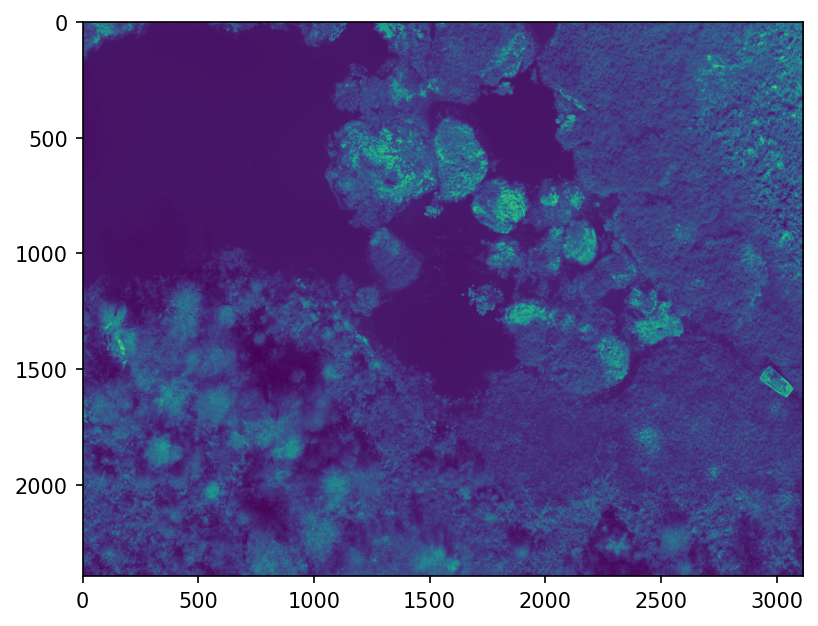

In [19]:
# Let's take a look at our data...
imblue = plt.imshow(blue)

# Looks a bit dark! Let's see if we can address that in the next section.

## Applying a stretch to the data

Much like ArcGIS, we can apply various stretches to normalize the data and make it easier to view. There
may be a fancier, faster way to do this, but we're going to leverage computing our own values for the imagery
bounds.

### Standard deviation stretch

Using NumPy, we calculate our mean and standard deviation, then compute the ranges on
each side. This gets passed to a Normalize function, which will be used when displaying the data.
The color maps can also be specified here if the default isn't appropriate for displaying the data.

The Normalize function is effectively setting values that are above and below the computed threshold to
the minimum and maximum value in the image. So all values below two standard deviations below the mean will
be displayed as the lowest displayed value, and all values above two standard deviations will be displayed
as the highest displayed value.

Standard deviation:  0.008330717
Mean:  0.015465911
Min value: -0.0011955229565501213
Max value: 0.03212734404951334


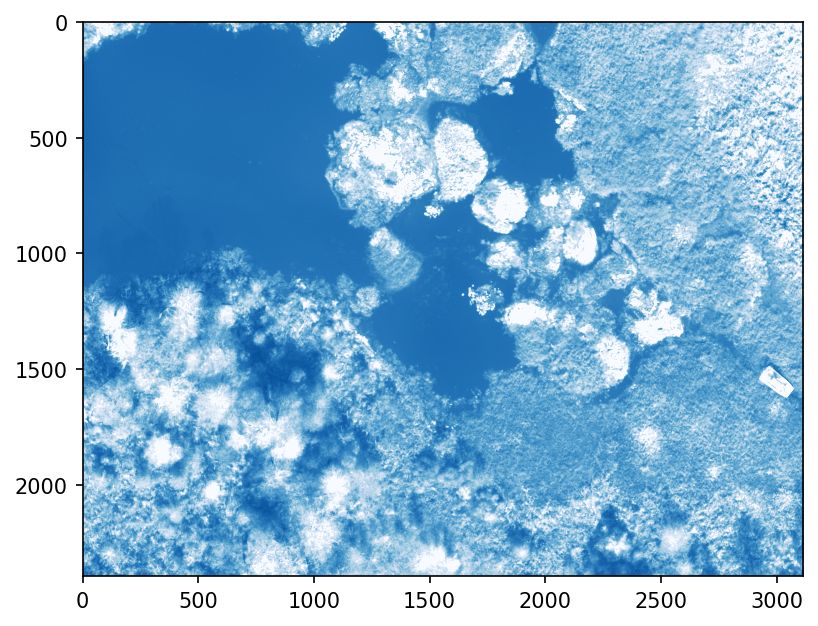

In [100]:
# Grab our standard deviation and mean. Will need it so we can scale our imagery
# more effectively. Currently using two standard deviations.
stdev = np.nanstd(blue)
mean = np.nanmean(blue)

print("Standard deviation: ", stdev)
print("Mean: ", mean)

blue_min_std = mean - (stdev*2)
blue_max_std = mean + (stdev*2)

print ("Min value:", blue_min_std)
print ("Max value:", blue_max_std)

# This calls our normalization function. The color map can be changed in the imshow
# call - there are many built-in options, and custom color maps can also be used.
normalize = colors.Normalize(vmin=blue_min_std, vmax=blue_max_std, clip=True)
imblue = plt.imshow(blue, cmap='Blues_r', norm=normalize)

### Percent clip stretch

Sometimes standard deviation stretches look great, but in this case, it feels a bit washed out, so let's
try a percent clip instead. Instead of using standard deviation, this will instead discard a certain percentage
of values, setting anything above and below to max and min values. This is very good to eliminate outlier values.
We can compute this using NumPy's percentile function.

In this case, we're going to clip two percent from the top and bottom of our dataset.

#### Quick note regarding the percentile function

To compute the boundary values, there are several methods to choose what those values are. In this case,
we're using linear, which interpolates values and as such the boundary value might not exist in the list.
This may or may not be okay depending on your dataset. Note that this option used to be "interpolation"
but is now "method", so be aware if you're using an older version of NumPy.

[0.006005   0.03828941]


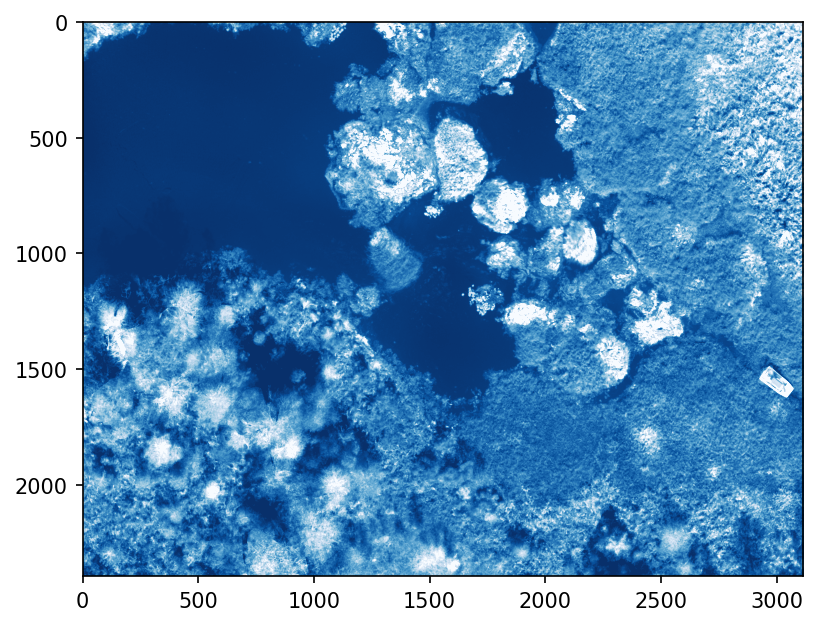

In [101]:
# Maybe we don't want to do a standard deviation stretch, but instead a percent clip. We can do this using
# NumPy's percentile function.

# Note that using "linear" will interpolate and produce values that may not exist in the array. This is
# fine for what we're doing, as we just want lower and upper bounds to adjust our data display range.

# May not work if older version of NumPy, changed from "interpolation" to "method", so add try/except block.
try:
    perc = np.percentile(blue, [2, 98], method="linear")
except:
    perc = np.percentile(blue, [2, 98], interpolation="linear")

print (perc)

# Call our normalize function as before.
normalize = colors.Normalize(vmin=perc[0], vmax=perc[1], clip=True)
imblue = plt.imshow(blue, cmap='Blues_r', norm=normalize)

[0.00338904 0.04233599]


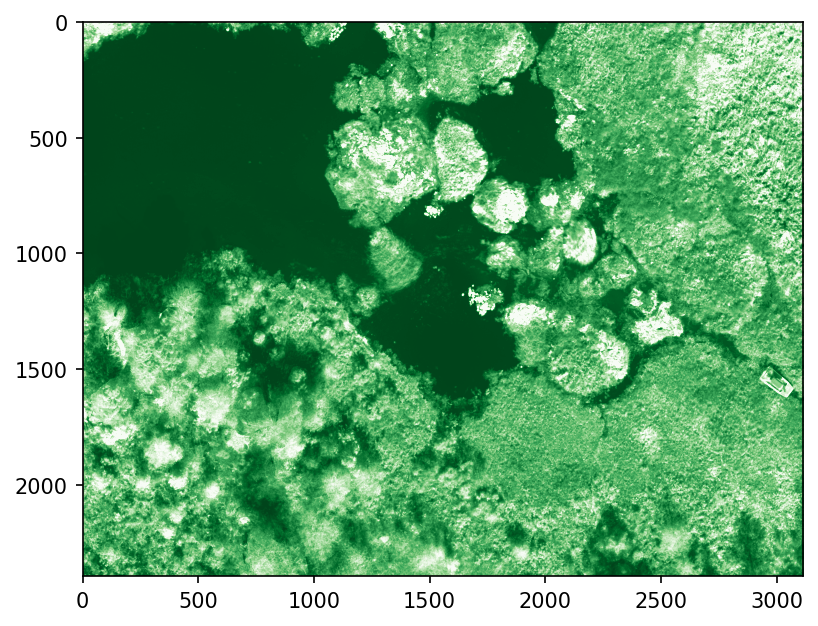

In [13]:
# Repeating for each band.
"""
stdev = np.nanstd(green)
mean = np.nanmean(green)

print(stdev)
print(mean)

green_min_std = mean - (stdev*2)
green_max_std = mean + (stdev*2)

normalize = colors.Normalize(vmin=green_min_std, vmax=green_max_std, clip=True)
imgreen = plt.imshow(green, cmap='Greens_r', norm=normalize)
"""

# May not work if older version of NumPy, changed from "interpolation" to "method", so add try/except block.
try:
    perc = np.percentile(green, [2, 98], method="linear")
except:
    perc = np.percentile(green, [2, 98], interpolation="linear")

print (perc)

# Call our normalize function as before.
normalize = colors.Normalize(vmin=perc[0], vmax=perc[1], clip=True)
imgreen = plt.imshow(green, cmap='Greens_r', norm=normalize)

[0.00295077 0.04479354]


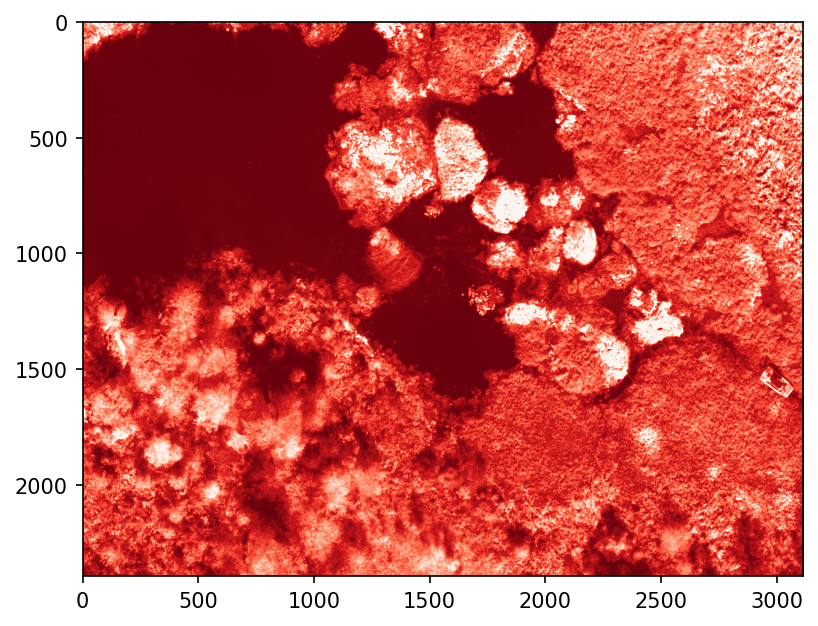

In [14]:
"""
stdev = np.nanstd(red)
mean = np.nanmean(red)

print(stdev)
print(mean)

red_min_std = mean - (stdev*2)
red_max_std = mean + (stdev*2)

normalize = colors.Normalize(vmin=red_min_std, vmax=red_max_std, clip=True)
imred = plt.imshow(red, cmap='Reds_r', norm=normalize)
"""
# May not work if older version of NumPy, changed from "interpolation" to "method", so add try/except block.
try:
    perc = np.percentile(red, [2, 98], method="linear")
except:
    perc = np.percentile(red, [2, 98], interpolation="linear")

print (perc)

# Call our normalize function as before.
normalize = colors.Normalize(vmin=perc[0], vmax=perc[1], clip=True)
imred = plt.imshow(red, cmap='Reds_r', norm=normalize)

[0.00239213 0.08847866]


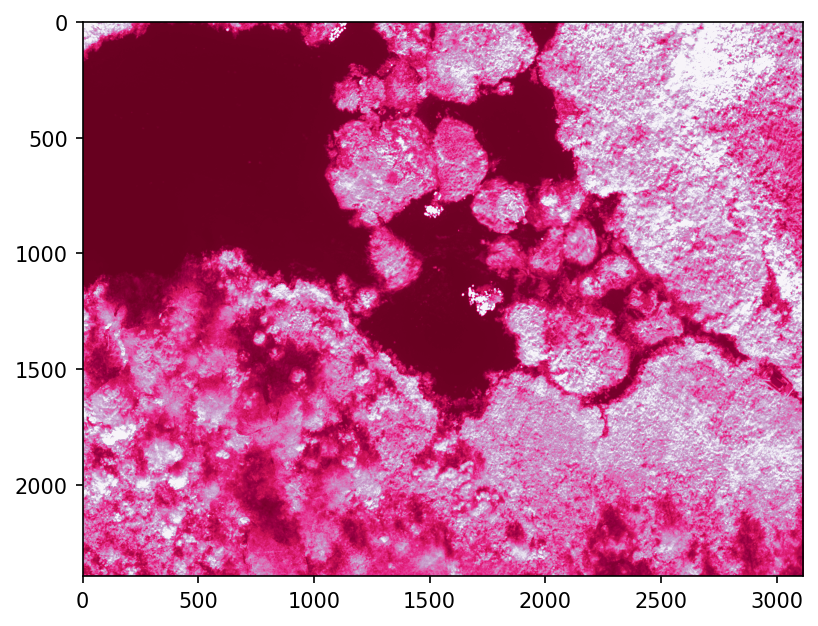

In [15]:
"""
stdev = np.nanstd(rededge)
mean = np.nanmean(rededge)

print(stdev)
print(mean)

rededge_min_std = mean - (stdev*2)
rededge_max_std = mean + (stdev*2)

normalize = colors.Normalize(vmin=rededge_min_std, vmax=rededge_max_std, clip=True)
imrededge = plt.imshow(rededge, cmap='PuRd_r', norm=normalize)
"""
# May not work if older version of NumPy, changed from "interpolation" to "method", so add try/except block.
try:
    perc = np.percentile(rededge, [2, 98], method="linear")
except:
    perc = np.percentile(rededge, [2, 98], interpolation="linear")

print (perc)

# Call our normalize function as before.
normalize = colors.Normalize(vmin=perc[0], vmax=perc[1], clip=True)
imrededge = plt.imshow(rededge, cmap='PuRd_r', norm=normalize)

[0.00240857 0.1535469 ]


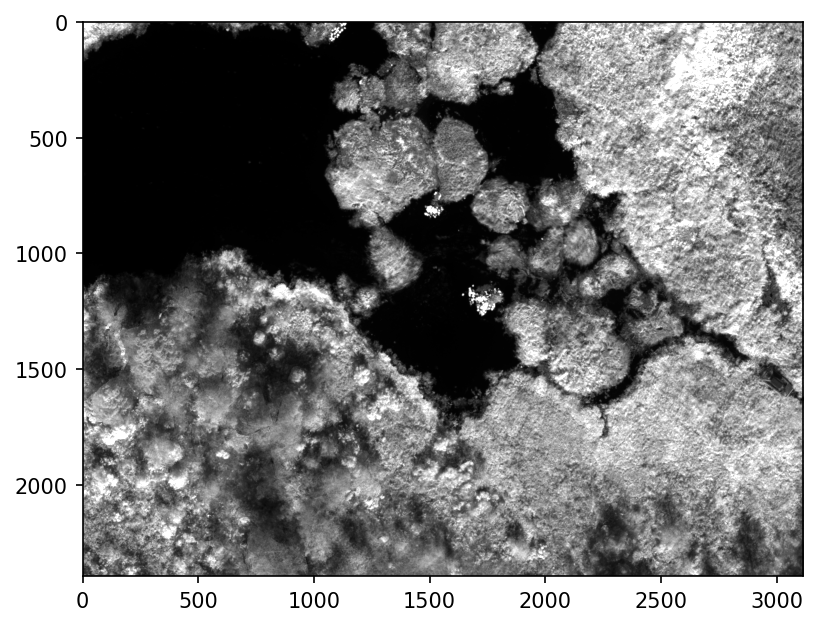

In [16]:
"""
stdev = np.nanstd(nir)
mean = np.nanmean(nir)

print(stdev)
print(mean)

nir_min_std = mean - (stdev*2)
nir_max_std = mean + (stdev*2)

normalize = colors.Normalize(vmin=nir_min_std, vmax=nir_max_std, clip=True)
imnir = plt.imshow(nir, cmap='gray', norm=normalize)
"""

# May not work if older version of NumPy, changed from "interpolation" to "method", so add try/except block.
try:
    perc = np.percentile(nir, [2, 98], method="linear")
except:
    perc = np.percentile(nir, [2, 98], interpolation="linear")

print (perc)

# Call our normalize function as before.
normalize = colors.Normalize(vmin=perc[0], vmax=perc[1], clip=True)
imnir = plt.imshow(nir, cmap='gray', norm=normalize)

## Computing NDWI

Remember from the start that we talked about NDWI, so now let's actually do the calculation for it. NDWI
is calculated by the following equation:

\begin{equation}
(Green - NIR) / (Green + NIR)
\end{equation}

We can do this directly on our entire NumPy arrays, so let's do that now and display it.

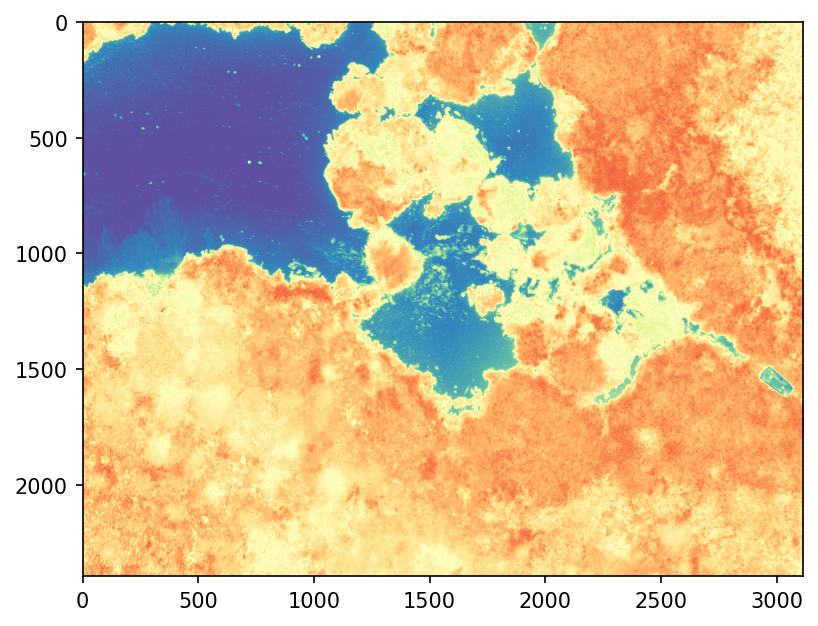

In [33]:
# Let's see about doing a simple land/water mask. Note that these can be notoriously tricky based
# on various factors such as sun glint, water turbidity, sedimentation, algal content, etc.

# First, let's create a NDWI image. There are two versions of NDWI, one of which uses SWIR and the other
# which uses the green band. We don't have SWIR, but that's primarily to look for water content in leaves,
# whereas the green band version looks for water in water bodies, which is what we want.

# NDWI is (Green - NIR)/(Green + NIR)
ndwi = (green - nir) / (green + nir)
stdev = np.nanstd(ndwi)
mean = np.nanmean(ndwi)

normalize = colors.Normalize(vmin=(mean - (stdev*2)), vmax=(mean + (stdev*2)), clip=True)
imndwi = plt.imshow(ndwi, cmap='Spectral', norm=normalize)

### Classifying NDWI Using a Simple Threshold

Going by what we learned about NDWI, we know that values greater than 0 are typically considered water
(or flooding/humidity), so we will use the NumPy where function to create a conditional that sets values
greater than 0 to a 1 (which we're going to consider water), and otherwise set it to a 2 (which we will
consider land).

We will also arbitrarily add a threshold check for NIR that says anything less than 0.1 should be water
and everything above is not, which may help with some false positives in NDWI.

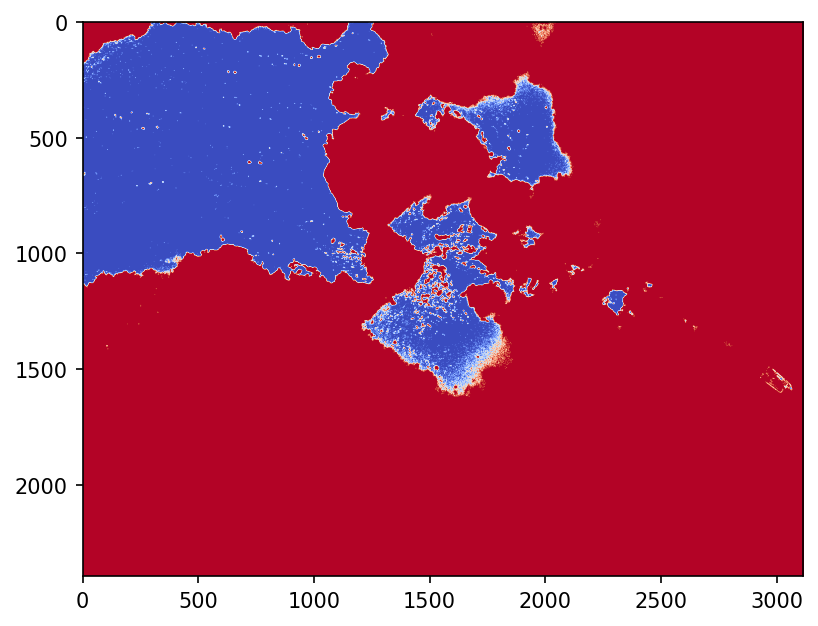

In [122]:
# Using somewhat arbitrary thresholds, let's compute a land/water mask. NDWI defines greater than zero
# as water. We'll also use our NIR band as well to apply a little extra filtering - sometimes NDWI can
# give some false readings, and NIR will help make sure we're not looking at something that's highly
# reflective in the NIR band (possibly in urban environments).

classified = np.where(((nir <= 0.1) & (ndwi >= 0)), 1, 2)
classified = np.where(np.isnan(nir), nir, classified)
imclass = plt.imshow(classified, cmap='coolwarm')

## Removing Noise From the Classification

This looks pretty decent, but there is some noise present, presumably from smaller objects or sun glint
or a host of other in-field issues. So... let's see if we can filter it a bit. First, we're going to try
running a Gaussian filter over the NDWI dataset. We'll employ a 5x5 kernel for the smoothing. We can do this
using OpenCV's "GaussianBlur" function.

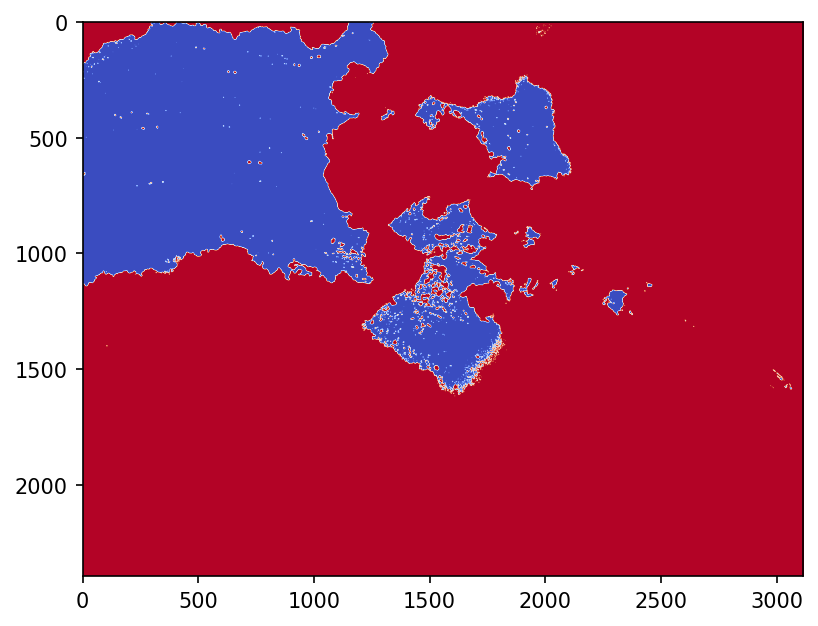

In [123]:
ndwi_blur = cv2.GaussianBlur(ndwi,(5,5),0)

classified = np.where(((nir <= 0.1) & (ndwi_blur >= 0)), 1, 2)
classified = np.where(np.isnan(nir), nir, classified)
imclass = plt.imshow(classified, cmap='coolwarm')

This is getting there, but let's do even more to remove some noise. We're going to use GDAL's "SieveFilter" function
to group pixels together, and eliminate pixel groups less than a given threshold. This function requires an actual
GeoTIFF to exist beforehand, so we will create an empty raster that matches our classified raster format.

In this case, we will use a threshold of 50, which will keep all connected pixel groups greater than 50 intact,
and pixel groups less than that to the adjacent pixel values instead.

The "connectedness" value determines how adjacent pixels are determined. By default, this is a 4, which means
we only count an adjacent pixel if it lies in a cardinal direction. Alternately, you can use a connectedness
of 8, which also considers diagonal pixels to the central pixel as connected.

### Note about dimensions

Be aware that the X and Y sizes might be in a different order when creating a GeoTIFF. In this case, they are
transposed from what the shape is of the classified NumPy array and what the GDAL driver expects.

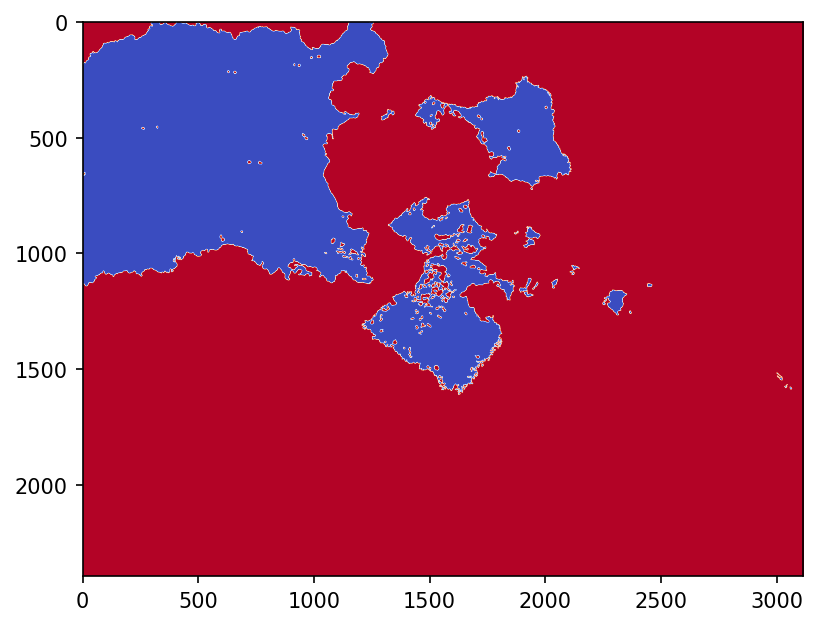

In [124]:
# We're going to try to filter our imagery a bit more, as this is a bit noisy-looking.


# First, we're going to take everywhere that is a NumPy NaN and turn back to zero. This will
# effectively become our nodata value.
classified_nodata = np.where(np.isnan(classified), 0, classified)

# We need to create a temporary GeoTIFF file to store our results in. Be careful with this,
# as the rows and columns may be transposed from what the NumPy array holds currently.
driver = gdal.GetDriverByName('GTiff')
outdata = driver.Create('{}'.format("filter.tif"), classified.shape[1], classified.shape[0], 1, \
                        gdal.GDT_Byte, options=['COMPRESS=DEFLATE'])

# Write our modified classified array to the GeoTIFF we just created, and make sure to add
# in our georeferencing as well.
outdata.GetRasterBand(1).WriteArray(classified_nodata)
outdata.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromWkt(wkt)
outdata.SetProjection(srs.ExportToWkt())

# Now we're going to use GDAL's SieveFilter function to group pixels. There are several options to
# change here, but we will stick with a connectedness of 4 (don't consider diagonal pixels adjacent),
# and a threshold value of 50 (groups of pixels smaller than 50 will be disregarded).

gdal.SieveFilter(srcBand=outdata.GetRasterBand(1), maskBand=None, dstBand=outdata.GetRasterBand(1), threshold=50, connectedness=4)
outdata.GetRasterBand(1).SetNoDataValue(0)
outdata.FlushCache()

# Let's take a look at the results!
flt = gdal.Open("filter.tif")
fltimg = flt.GetRasterBand(1).ReadAsArray()
nodata = flt.GetRasterBand(1).GetNoDataValue()
fltimg = np.where(fltimg == nodata, np.nan, fltimg)
imflt = plt.imshow(fltimg, cmap='coolwarm')

## Converting the Classification to a Shapefile

Having a classification is useful, but often we don't want to distribute this sort of information as a raster,
but instead as a shapefile. We can convert this raster to a shapefile as well. We can use OGR from GDAL to
create a shapefile, and then create layers and fields in that shapefile.

After this, we can use the "Polygonize" function to convert the raster areas into a polygon shapefile.

In [16]:
# Convert GeoTIFF to shapefile.

# Jupyter notebook tends to hold on to this file, so need to manually delete if re-running
# this is desired.

if not os.path.exists("filter.shp"):
    
    dstlayername = "filter.shp"
    drv = ogr.GetDriverByName("ESRI Shapefile")
    dstds = drv.CreateDataSource(dstlayername)

    # Make sure that a value field exists in the shapefile so that when we call
    # Polygonize the values will migrate over.
    dstlayer = dstds.CreateLayer(dstlayername, srs=srs, geom_type=ogr.wkbMultiPolygon)
    datafield = ogr.FieldDefn('Value', ogr.OFTInteger)
    dstlayer.CreateField(datafield)
    dstfield = dstlayer.GetLayerDefn().GetFieldIndex("Value")
    
    # Call Polygonize to change the raster to polygons. The "8CONNECTEDNESS" field may not
    # be necessary depending on how you want to group pixels (only adjacent in four cardinal
    # directions or also on diagonals).
    gdal.Polygonize(flt.GetRasterBand(1), None, dstlayer, dstfield, ["8CONNECTEDNESS=8"], callback=None)
    dstds.SyncToDisk()
    dstds=None

This is going to closely follow the raster lines, so it will have a jagged appearance. Maybe we don't
want that, so we can simplify our shapefile above to have simpler shapes using the "Simplify" function.

### Note about simplification
The simplification may actually remove shapes entirely if they're rather small or already very simple.

In [17]:
# Now perhaps we want to simplify this shapefile to be a bit less pixelated.

dstlayername = "filter_simple.shp"
drv = ogr.GetDriverByName("ESRI Shapefile")
dstds = drv.CreateDataSource(dstlayername)
dstlayer = dstds.CreateLayer(dstlayername, srs=srs, geom_type=ogr.wkbMultiPolygon)

# We want to keep all our fields from the prior shapefile, so create both fields
# to match, including FID.
datafield = ogr.FieldDefn('Value', ogr.OFTInteger)
dstlayer.CreateField(datafield)
datafield = ogr.FieldDefn('FID', ogr.OFTInteger)
dstlayer.CreateField(datafield)

shp = ogr.Open('filter.shp')
# Grab the layer.
layer = shp.GetLayer()
# Find out how many features (polygons) are in our layer.
numfeatures = layer.GetFeatureCount()

# Iterate through each feature in the shapeifle and simplify the geometry.
# Note that this may actually completely remove some shapes.
for i in range(0, numfeatures):
    feature = layer.GetFeature(i)
    geometry = feature.geometry()
    feature.SetGeometry(geometry.Simplify(0.1))
    dstlayer.CreateFeature(feature)
    #print(filter_simple)
    #print(geometry)

dstds.SyncToDisk()
dstds=None
shp=None

## Adding Otsu's Method For Binary Thresholding
Otsu's method is a technique for looking at bimodal distributions and determining the optimal split
point for that distribution. The paper here argues for using Otsu's method for adjusting the
threshold for various NDWI indices based on the area, image quality, lighting conditions, and so
forth.

https://doi.org/10.1016/j.envsoft.2021.105030

### Applying Otsu's method to the NIR band only

Technically outside of the scope of the paper above, but if we were to only use the NIR band to
attempt water delineation, then we might still use Otsu's method to split out our distribution.

#### Converting from 32-bit float to 8-bit integer array

Otsu's method, as implemented in OpenCV, only supports 8-bit grayscale imagery. Our NIR data
is already grayscale since we've only selected that band, but it is in floating-point format,
so we need to convert to 8-bit. Note that we will lose some granularity in this conversion.

#### Applying the threshold

The "threshold" function can give us both an image as well as the actual threshold values. We're
doing a binary threshold, and to specify that we're using Otsu's method, we also need to add in
"cv2.THRESH_OTSU" to work. We can convert the image output and our threshold back to floating-point
and our image classes after we get them back.

0.054901960784313725
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


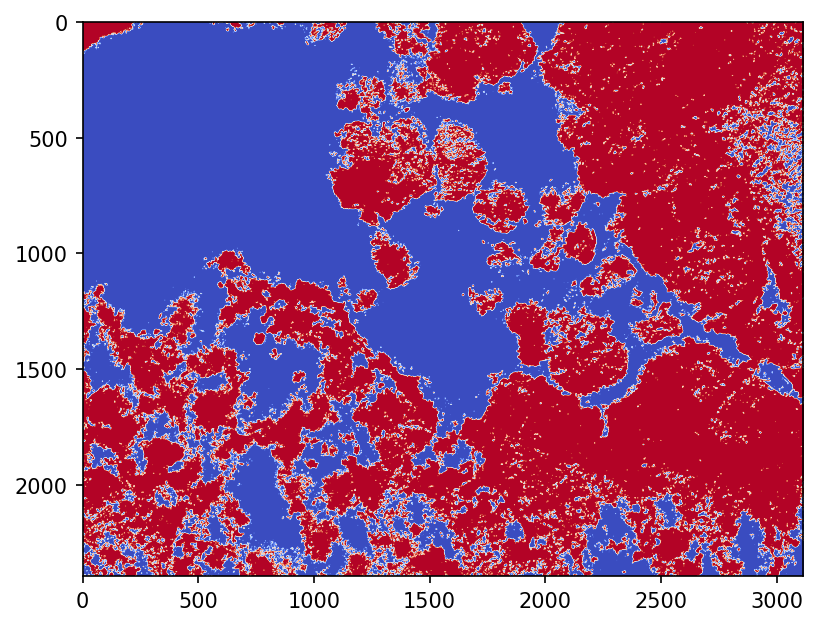

In [111]:
# Turns out Otsu's threshold in OpenCV wants an 8-bit array. Let's oblige them.
nir8bit = np.array(nir*255, dtype='uint8')

# Use Otsu's method to compute an automatic threshold.
otsu_threshold, image_result = cv2.threshold(nir8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

otsu_threshold_float = otsu_threshold / 255.0
print ("Threshold:", otsu_threshold_float)

print (image_result)

# Remap to 1 and 2 for values, aligning with our previous classification values.
newarr = np.where(image_result == 255, 2, image_result)
newarr = np.where(newarr == 0, 1, newarr)

print (newarr)
# And now we can compare this result to our initial classification.
otsuimg = plt.imshow(newarr, cmap='coolwarm')

Whew, looking pretty noisy! In some ways it's capturing more of the water than the last attempt, though. This
is a pretty challenging environment for NDWI, as it's in a marshy wetland area, and much of what is visible
is aquatic plants both native and invasive.

0.054901960784313725
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[[2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


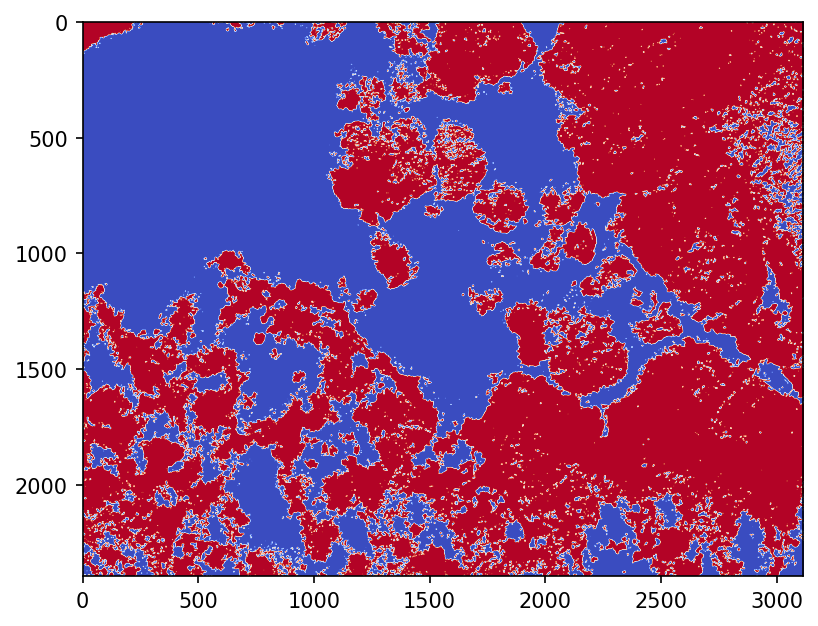

In [112]:
# Let's try a gaussian filter on this.
nir8bit = cv2.GaussianBlur(nir8bit,(5,5),0)

# Use Otsu's method to compute an automatic threshold.
otsu_threshold, image_result = cv2.threshold(nir8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
otsu_threshold_float = otsu_threshold / 255.0
print (otsu_threshold_float)

print (image_result)

# remap to 1 and 2 for values.
newarr = np.where(image_result == 255, 2, image_result)
newarr = np.where(newarr == 0, 1, newarr)

print (newarr)
# And now we can compare this result to our initial classification.
otsuimg = plt.imshow(newarr, cmap='coolwarm')

[[45 45 43 ... 75 85 90]
 [46 45 44 ... 75 83 87]
 [45 44 43 ... 74 79 82]
 ...
 [45 45 43 ... 62 62 62]
 [47 47 46 ... 64 64 64]
 [47 47 47 ... 65 65 65]]
Threshold: -0.25
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


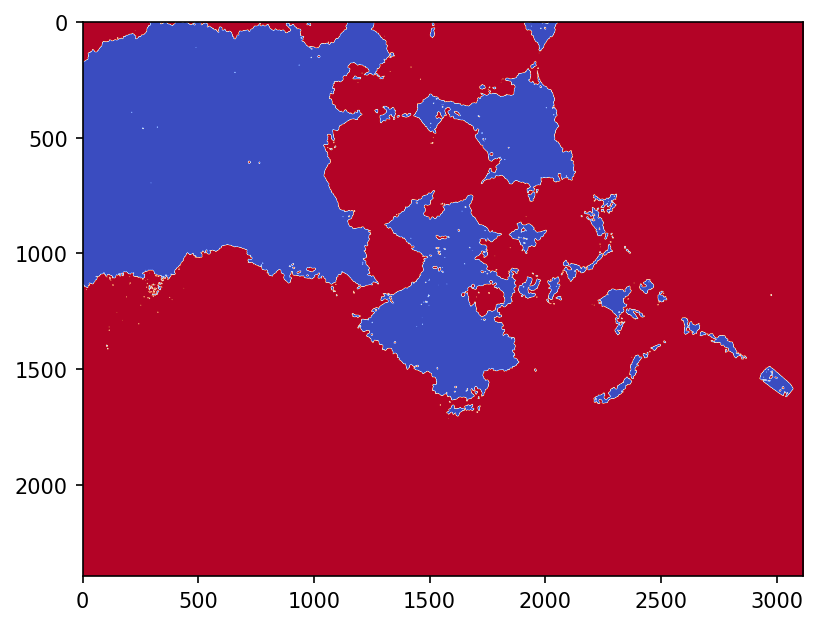

In [118]:
# Turns out Otsu's threshold in OpenCV wants an 8-bit array. Let's oblige them.
# NDWI is from -1 to 1, so... have to scale it differently.
# Also going to use Gaussian blur version.
ndwi8bit = np.array((ndwi_blur+1.0)*128, dtype='uint8')
print (ndwi8bit)

otsu_threshold, image_result = cv2.threshold(ndwi8bit, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
otsu_threshold_float = (otsu_threshold/128.0) - 1.0
print ("Threshold:", otsu_threshold_float)
newarr2 = np.where(image_result == 0, 1, image_result)
newarr2 = np.where(newarr2 == 255, 2, newarr2)
otsuimg = plt.imshow(newarr2, cmap='coolwarm')
print (image_result)

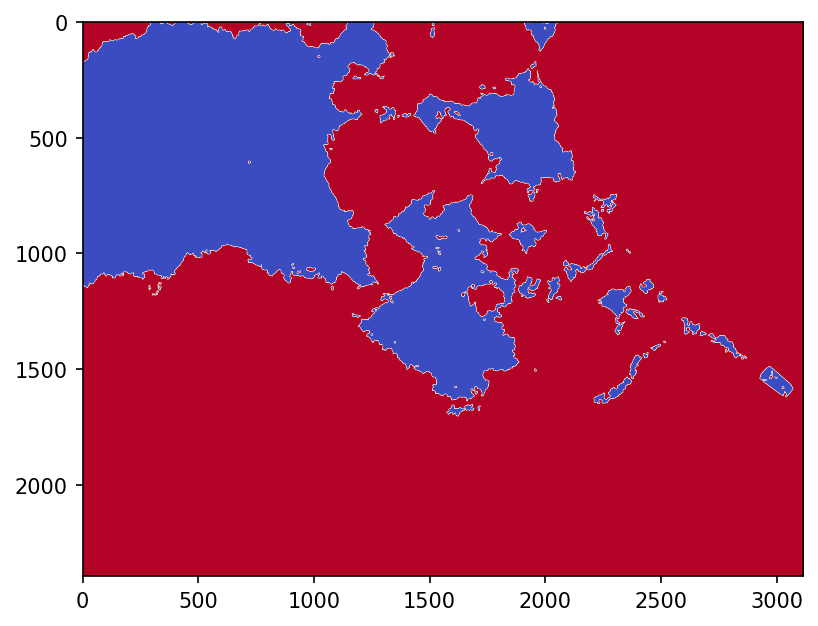

In [125]:
# We're going to try to filter our imagery a bit more, as this is a bit noisy-looking.


# First, we're going to take everywhere that is a NumPy NaN and turn back to zero. This will
# effectively become our nodata value.
newarr2_nodata = np.where(np.isnan(newarr2), 0, newarr2)

# We need to create a temporary GeoTIFF file to store our results in. Be careful with this,
# as the rows and columns may be transposed from what the NumPy array holds currently.
driver = gdal.GetDriverByName('GTiff')
outdata = driver.Create('{}'.format("filter_otsu.tif"), classified.shape[1], classified.shape[0], 1, \
                        gdal.GDT_Byte, options=['COMPRESS=DEFLATE'])

# Write our modified classified array to the GeoTIFF we just created, and make sure to add
# in our georeferencing as well.
outdata.GetRasterBand(1).WriteArray(newarr2_nodata)
outdata.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromWkt(wkt)
outdata.SetProjection(srs.ExportToWkt())

# Now we're going to use GDAL's SieveFilter function to group pixels. There are several options to
# change here, but we will stick with a connectedness of 4 (don't consider diagonal pixels adjacent),
# and a threshold value of 50 (groups of pixels smaller than 50 will be disregarded).

gdal.SieveFilter(srcBand=outdata.GetRasterBand(1), maskBand=None, dstBand=outdata.GetRasterBand(1), threshold=50, connectedness=4)
outdata.GetRasterBand(1).SetNoDataValue(0)
outdata.FlushCache()

# Let's take a look at the results!
flt_otsu = gdal.Open("filter_otsu.tif")
flt_otsu_img = flt_otsu.GetRasterBand(1).ReadAsArray()
nodata = flt.GetRasterBand(1).GetNoDataValue()
flt_otsu_img = np.where(flt_otsu_img == nodata, np.nan, flt_otsu_img)
imflt_otsu = plt.imshow(flt_otsu_img, cmap='coolwarm')

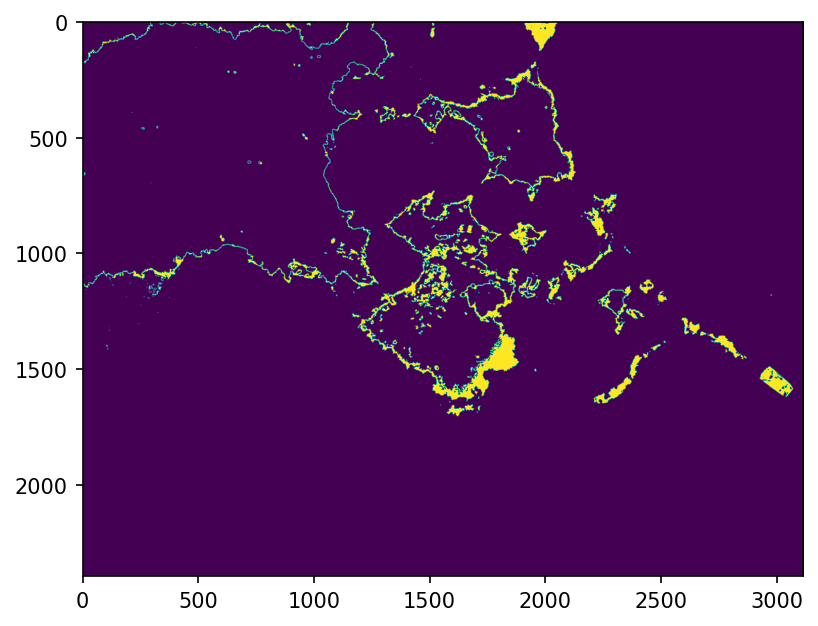

In [126]:
# Let's take a look at the difference between this and our original version.

diff = np.where(newarr2 != fltimg, 2, 1)
plt.imshow(diff)